** 멀티라벨 분류 **

비행기, 불상, 나비, 게 4가지의 이미지를 분류해본다

기본적인 방법은 단일 이미지 분류와 같다. 대신, 다중 이미지 분류이기 때문에 카테고리의 변화가 있다.

그리고 단일 보다 데이터셋이 현저히 부족하다. 이는 데이터셋을 잘 못모은 내 잘못이다.

미리 양해를 구한다.


In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./multi_img_data/imgs_others/train"
categories = ["airplanes", "buddha", "butterfly", "crab"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))


airplanes  파일 길이 :  793
airplanes  :  ./multi_img_data/imgs_others/train/airplanes\image_0008.jpg
airplanes  :  ./multi_img_data/imgs_others/train/airplanes\image_0708.jpg
buddha  파일 길이 :  947
buddha  :  ./multi_img_data/imgs_others/train/buddha\image_0007.jpg
buddha  :  ./multi_img_data/imgs_others/train/buddha\plus_3418_0_4375.jpg
butterfly  파일 길이 :  1020
butterfly  :  ./multi_img_data/imgs_others/train/butterfly\image_0007.jpg
butterfly  :  ./multi_img_data/imgs_others/train/butterfly\plus_3496_0_9956.jpg
crab  파일 길이 :  804
crab  :  ./multi_img_data/imgs_others/train/crab\image_0007.jpg
crab  :  ./multi_img_data/imgs_others/train/crab\plus_3583_0_393.jpg
ok 3564


이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [15]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

(2673, 64, 64, 3)
2673


In [16]:
categories = ["airplanes", "buddha", "butterfly", "crab"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [17]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
__________

In [19]:

#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 2673 samples, validate on 891 samples
Epoch 1/50
2673/2673 [==============================] - 3s 976us/step - loss: 1.3855 - acc: 0.4074 - val_loss: 0.9156 - val_acc: 0.5713

Epoch 00001: val_loss improved from inf to 0.91558, saving model to ./model/multi_img_classification.model
Epoch 2/50
2673/2673 [==============================] - 2s 623us/step - loss: 0.8363 - acc: 0.6450 - val_loss: 0.7667 - val_acc: 0.6667

Epoch 00002: val_loss improved from 0.91558 to 0.76669, saving model to ./model/multi_img_classification.model
Epoch 3/50
2673/2673 [==============================] - 2s 609us/step - loss: 0.6617 - acc: 0.7153 - val_loss: 0.6959 - val_acc: 0.7217

Epoch 00003: val_loss improved from 0.76669 to 0.69590, saving model to ./model/multi_img_classification.model
Epoch 4/50
2673/2673 [==============================] - 2s 623us/step - loss: 0.5541 - acc: 0.7740 - val_loss: 0.5858 - val_acc: 0.7329

Epoch 00004: val_loss improved from 0.69590 to 0.58579, saving model to ./mo

In [20]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

891/891 [==============================] - ETA:  - 0s 216us/step
정확도 : 0.9024


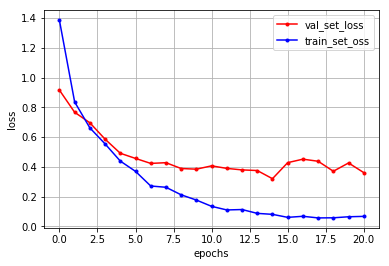

In [21]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [22]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./multi_img_data/imgs_others_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "비행기"
    elif pre_ans == 1: pre_ans_str = "불상"
    elif pre_ans == 2: pre_ans_str = "나비"
    else: pre_ans_str = "게"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


[0.000 0.000 0.000 1.000]
3
해당 게1.PNG이미지는 게로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 게2.PNG이미지는 게로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 게3.PNG이미지는 게로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 나비1.PNG이미지는 나비로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 나비2.PNG이미지는 나비로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 나비3.PNG이미지는 나비로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 뱅기1.PNG이미지는 비행기로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 뱅기2.PNG이미지는 비행기로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 뱅기3.PNG이미지는 비행기로 추정됩니다.
[0.000 1.000 0.000 0.000]
1
해당 불상1.PNG이미지는 불상으로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 불상2.PNG이미지는 게로 추정됩니다.
[0.000 1.000 0.000 0.000]
1
해당 불상3.PNG이미지는 불상으로 추정됩니다.


비록 데이터가 적지만 그래도 나름 학습이 잘 되었습니다.

하지만 **validation data와 test data가 나뉘어져 있지 않습니다.**

이는 매우 위험한 시도입니다. 왜냐하면 검증 단계에서 테스트 데이터를 사용했는데 또 마지막에 정확도 검출 시 test_data를 사용합니다.

데이터가 충분하다면 이런짓은 하지 않는게 좋습니다!

하지만 새로운 데이터에 대한 예측은 그래도 잘 하는군요!